# Tilt and Compliance Corrections for OBS Data
This notebook contains the examples of conducting tilt and compliance corrections for OBS records. Examples in this notebook download earthquake catalog and associated data. The purpose is to validate the corrections using earthquake data. For the theoretical backgrund of tilt and compiance corrections, please read Bell et al. (2015, BSSA).

### References:
1. Bell, S. W., D. W. Forsyth, & Y. Ruan (2015), Removing Noise from the Vertical Component Records of Ocean-Bottom Seismometers: Results from Year One of the Cascadia Initiative, Bull. Seismol. Soc. Am., 105(1), 300-313, doi:10.1785/0120140054.

## Step-1. Import needed packages.

In [1]:
#import needed packages.
from collections import OrderedDict
from utilities import sta_info_from_inv,plot_trace,segment_interpolate
from utilities import qml_to_event_list
from TCcorrection_funcs import docorrection,gettransfer, maxcompfreq
import sys
import time
import scipy
import obspy
import datetime
import os, glob
import numpy as np
import matplotlib.pyplot  as plt
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from IPython.display import clear_output
from obspy.core.event import Catalog
from obspy.geodetics.base import gps2dist_azimuth
try:
    from obspy.core.event import readEvents
except Exception as e:
    from obspy import read_events as readEvents

## Step-2. Get earthquake catalog with specified date range.
In this example, I only use one day to get the earthquakes. The codes can be modified to work on a broader range of time for earthquake catalog. The earthquake catalog is retrieved from GCMT catalog.

In [ ]:
evt_start= '2012-01-01'
evt_end = '2012-01-31'
evlon_min = -133
evlon_max = -116
evlat_min = 38
evlat_max = 52
evmag_min = 5.0
evmag_max = 10.0
evdep_min = 0
evdep_max = 100

cat=Catalog()
cat = readEvents('http://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/COMBO/combo.ndk')
# cat=readEvents('./gcmtcombo.ndk')
filt1 = 'time >= %s' % evt_start
filt2 = 'time <= %s' % evt_end
cat = cat.filter(filt1, filt2)

filt1 = 'magnitude >= %s' % evmag_min
filt2 = 'magnitude <= %s' % evmag_max
cat = cat.filter(filt1, filt2)

filt1 = 'depth >= %s' % (float(evdep_min)*1000.)
filt2 = 'depth <= %s' % (float(evdep_max)*1000.)
cat = cat.filter(filt1, filt2)

if None not in [evlat_min, evlat_max, evlon_min, evlon_max]:
    filt1 = 'latitude >= %s' % evlat_min
    filt2 = 'latitude <= %s' % evlat_max
    cat = cat.filter(filt1, filt2)

    filt1 = 'longitude >= %s' % evlon_min
    filt2 = 'longitude <= %s' % evlon_max
    cat = cat.filter(filt1, filt2)

#
events=qml_to_event_list(cat)


## Step-3. Get earthquake and station list based on the event information.
In step-2, I dowloaded all earthquakes within the date range. For the purpose of this test, I narrow down the earthquake list (i.e., only the rist one for now).

In [ ]:
ev=events[0] #only work on the first event for now.
print(ev)
evlon=ev['longitude']
evlat=ev['latitude']
evdep=ev['depth']

client    = Client('IRIS')
# netall="7D"
stlamin,stlamax,stlomin,stlomax= 37.0,52.0,-133.0,-116.0
Pchanlist=["HDH","BDH"] #pressure channels
# starttime = obspy.UTCDateTime("2012_01_21_0_0_0")       
# endtime   = obspy.UTCDateTime("2012_01_22_0_0_0")
preset=200 #seconds before the origin time
offset=3600 #seconds after the origin time
starttime = ev['datetime'] - preset
endtime = ev['datetime'] + offset

pchanfound=0
try:
    sta_invP0 = client.get_stations(network='7D',station='*',channel='*DH',location='*', \
                    starttime=starttime,endtime=endtime,minlatitude=stlamin,maxlatitude=stlamax, \
                    minlongitude=stlomin, maxlongitude=stlomax,level='response')

    pchanfound=1
except Exception as e:
    pchanfound == 0

staall,netall,lonall,latall,elvall,locationall=sta_info_from_inv(sta_invP0)
# print(sta,netall,lon,lat,elv,location)          


## Step-4. Run codes for tilt and compliance corrections.
The current codes only do compliance corrections.

In [15]:
# get data from IRIS web service
rmresp=True #remove instrument response
rmrespoutput="DISP"
# parameters for butterworth filter
samp_freq=20
pfreqmin=0.005
pfreqmax=samp_freq/2

# prefilter information used when removing instrument responses
f1 = 0.9*pfreqmin;f2=pfreqmin
if 1.1*pfreqmax > 0.45*samp_freq:
    f3 = 0.4*samp_freq
    f4 = 0.45*samp_freq
else:
    f3 = pfreqmax
    f4= 1.1*pfreqmax
pre_filt  = [f1,f2,f3,f4]

# get relationship between water depth and maximum compliance frequency.
d=np.arange(1,5051,50) #water depth
f=maxcompfreq(d,iplot=True)
trmaster=[]
trlabelsmaster=[]
distall=[]
for i in range(len(staall)):
    ista=staall[i]
    net=netall[i]
    clear_output(wait=True)
    trall=[] 
    stinv=[]
    trlabels=[]
    """
    array to save all four set of traces: 0-pressure, 1-vertical, 2-prediction of vertical from pressure,
    3-corrected vertical
    """
    
    #download pressure data first
    pchanfound=0
    for chan in Pchanlist:
        try:
            sta_invP = client.get_stations(network=net,station=ista,channel=chan,location='*', \
                            starttime=starttime,endtime=endtime,minlatitude=stlamin,maxlatitude=stlamax, \
                            minlongitude=stlomin, maxlongitude=stlomax,level='response')
            print()
            pchan=chan
            pchanfound=1
            break
        except Exception as e:
            pchanfound == 0
            
    if pchanfound == 0 and chan == Pchanlist[-1]:
        print("Pressure channels not found for "+net+"."+ista)
        continue
    sta,net,lon,lat,elv,location=sta_info_from_inv(sta_invP)
    dist=gps2dist_azimuth(lat,lon,evlat,evlon)
    stinv.append(sta_invP)
    trlabels.append(net+"."+ista+"."+pchan+":"+str(np.abs(elv))+"m:pressure")
    print("pressure channel "+pchan)
    try:
        tr=client.get_waveforms(network=net,station=ista,\
                        channel=pchan,location="*",starttime=starttime,endtime=endtime)
        tr.detrend("spline", order=3, dspline=500)
        trall.append(tr[0])
    except Exception as e:
        print(e)
        print(trlabels[0])
        continue

    #download vertical data now
    zchan=pchan[0]+"HZ"
    try:
        sta_invZ = client.get_stations(network=net,station=ista,channel=zchan,location='*', \
                        starttime=starttime,endtime=endtime,minlatitude=stlamin,maxlatitude=stlamax, \
                        minlongitude=stlomin, maxlongitude=stlomax,level='response')

        stinv.append(sta_invZ)
    except Exception as e:
        print(e)
        continue
    print("vertical channel "+zchan)
    trlabels.append(net+"."+ista+"."+zchan+":"+str(np.abs(elv))+"m:vertical")
    try:
        tr=client.get_waveforms(network=net,station=ista,\
                        channel=zchan,location="*",starttime=starttime,endtime=endtime)
        tr.detrend("spline", order=3, dspline=500)
        trall.append(tr[0])
    except Exception as e:
        print(e)
        print(trlabels[1])
        continue

    sps=int(trall[0].stats.sampling_rate) #assume pressure and vertical channels have the same sampling rat
    # make downsampling if needed
    if sps > samp_freq:
        # downsampling here
        print("resampling from "+str(sps)+" to "+str(samp_freq))
        for it in range(len(trall)):
            trall[it].interpolate(samp_freq,method='weighted_average_slopes')
            delta = trall[it].stats.delta

            # when starttimes are between sampling points
            fric = trall[it].stats.starttime.microsecond%(delta*1E6)
            if fric>1E-4:
                trall[it].data = segment_interpolate(np.float32(trall[it].data),float(fric/(delta*1E6)))
                #--reset the time to remove the discrepancy---
                trall[it].stats.starttime-=(fric*1E-6)

    #remove response from the two downloaded channels
    if rmresp:
        for it in range(len(trall)):
            if it == 0:continue #skip pressure channel
            if not stinv[it][0][0][0].response:
                raise ValueError('no response found in the inventory! abort!')
            else:
                try:
                    print('removing response for %s using inv'%trall[it])
                    trall[it].attach_response(stinv[it])
                    trall[it].remove_response(output=rmrespoutput,pre_filt=pre_filt,water_level=60)
                except Exception as e:
                    print(e)
                    trall[it] = []
           
    #start compliance correction
    #get the transfer function
    freqmin=pfreqmin
    freqmax=np.around(maxcompfreq(np.abs(elv)),decimals=3)
#     freqmin=0.01
#     freqmax=0.025
    delta=1.0/samp_freq
    print("getting transfer function ...")
#     trall[0].data=1000*trall[0].data #change from kpa to pa
    ff,coh,adm,phs,adm_err,phs_err = gettransfer(trall[0].data,trall[1].data,\
                                                 delta,iplot=False,winlen=250,\
                                                figname=net+"."+ista+"."+pchan+"-"+zchan+"_debug_transfer.png")
    if np.isnan(np.sum(adm)):
        print("getting transfer function found nan in adm. skip to the next station.")
        continue
        
    # do correction now.
    print("doing correction ...")
    trZ_pred,trZ_left = docorrection(trall[0],trall[1],adm,adm_err,phs,phs_err,\
                                     freqmin,freqmax,ff,iplot=0)

    trall.append(trZ_pred)
    trlabels.append(net+"."+ista+"."+zchan+":"+str(np.abs(elv))+"m:prediction")
    trall.append(trZ_left)
    trlabels.append(net+"."+ista+"."+zchan+":"+str(np.abs(elv))+"m:compliance corrected")

    trmaster.append(trall)
    trlabelsmaster.append(trlabels)
    distall.append(dist)
        
    
    
    



pressure channel BDH
vertical channel BHZ
resampling from 50 to 20
removing response for 7D.M08A..BHZ | 2012-01-13T19:42:48.700000Z - 2012-01-13T20:46:08.650000Z | 20.0 Hz, 76000 samples using inv
getting transfer function ...
doing correction ...


## Step-5. Now we start plotting the traces against distance.
Data from each receiver contains four traces: pressure, vertical, predicted vertical, and corrected vertical.

plotting ...


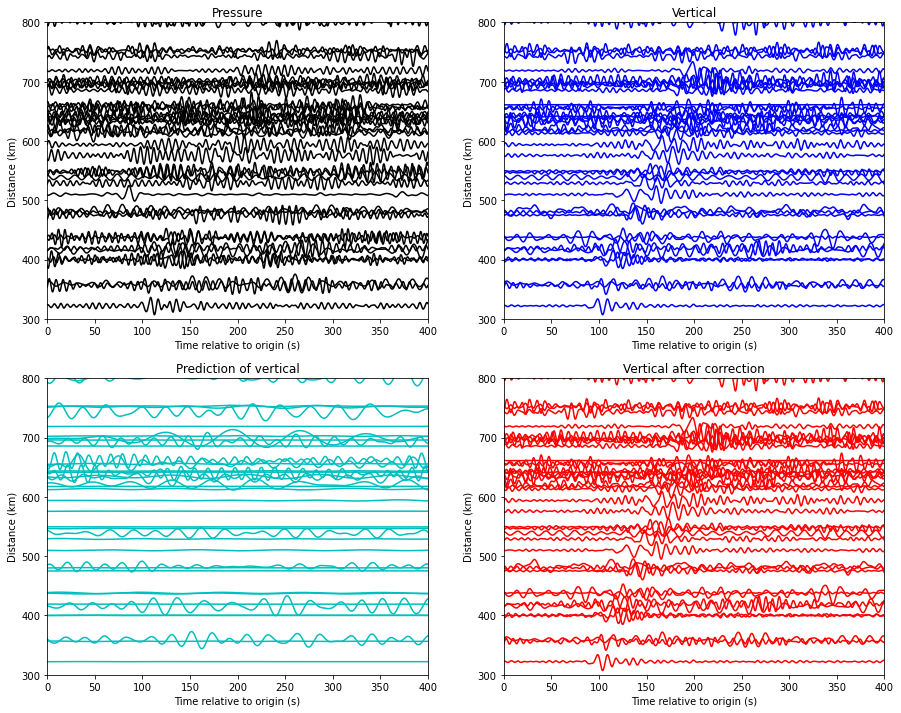

In [20]:
#plotting
print("plotting ...")
pfreqmin=0.02
pfreqmax=0.1
xlimit=[0, 400]
ylimit=[300, 800]
scale=15
figsize=[15,12]
plt.figure(figsize=figsize)

plt.subplot(2,2,1)
for i in range(len(trmaster)):
    tc=trmaster[i][0].copy()
    tt=tc.times();
    if len(xlimit)>0:
        imin = np.searchsorted(tt,xlimit[0],side="left")
        imax = np.searchsorted(tt,xlimit[1],side="left")
    else:
        imin=0
        imax=len(tc.data)-1
    
    tc.filter('bandpass',freqmin=pfreqmin,freqmax=pfreqmax)
    dtemp=tc.data/np.max(np.abs(tc.data[imin:imax]))
    plt.plot(tt-preset,distall[i][0]/1000 + scale*dtemp,'k')
    plt.xlim(xlimit)
    plt.ylim(ylimit)
    plt.xlabel('Time relative to origin (s)')
    plt.ylabel('Distance (km)')
    plt.title('Pressure: ['+str(pfreqmin)+', '+str(pfreqmax)+'] Hz')
# plt.close()

plt.subplot(2,2,2)
for i in range(len(trmaster)):
    tc=trmaster[i][1].copy()
    tt=tc.times();
    if len(xlimit)>0:
        imin = np.searchsorted(tt,xlimit[0],side="left")
        imax = np.searchsorted(tt,xlimit[1],side="left")
    else:
        imin=0
        imax=len(tc.data)-1
    tc.filter('bandpass',freqmin=pfreqmin,freqmax=pfreqmax)
    dtemp=tc.data/np.max(np.abs(tc.data[imin:imax]))
    plt.plot(tt-preset,distall[i][0]/1000 + scale*dtemp,'b')
    plt.xlim(xlimit)
    plt.ylim(ylimit)
    plt.xlabel('Time relative to origin (s)')
    plt.ylabel('Distance (km)')
    plt.title('Vertical: ['+str(pfreqmin)+', '+str(pfreqmax)+'] Hz')
# plt.close()    

plt.subplot(2,2,3)
for i in range(len(trmaster)):
    tc=trmaster[i][2].copy()
    tt=tc.times();
    if len(xlimit)>0:
        imin = np.searchsorted(tt,xlimit[0],side="left")
        imax = np.searchsorted(tt,xlimit[1],side="left")
    else:
        imin=0
        imax=len(tc.data)-1
    tc.filter('bandpass',freqmin=pfreqmin,freqmax=pfreqmax)
    dtemp=tc.data/np.max(np.abs(tc.data[imin:imax]))
    plt.plot(tt-preset,distall[i][0]/1000 + scale*dtemp,'c')
    plt.xlim(xlimit)
    plt.ylim(ylimit)
    plt.xlabel('Time relative to origin (s)')
    plt.ylabel('Distance (km)')
    plt.title('Prediction of vertical: ['+str(pfreqmin)+', '+str(pfreqmax)+'] Hz')
# plt.close()

plt.subplot(2,2,4)
for i in range(len(trmaster)):
    tc=trmaster[i][3].copy()
    tt=tc.times();
    if len(xlimit)>0:
        imin = np.searchsorted(tt,xlimit[0],side="left")
        imax = np.searchsorted(tt,xlimit[1],side="left")
    else:
        imin=0
        imax=len(tc.data)-1
    tc.filter('bandpass',freqmin=pfreqmin,freqmax=pfreqmax)
    dtemp=tc.data/np.max(np.abs(tc.data[imin:imax]))
    plt.plot(tt-preset,distall[i][0]/1000 + scale*dtemp,'r')
    plt.xlim(xlimit)
    plt.ylim(ylimit)
    plt.xlabel('Time relative to origin (s)')
    plt.ylabel('Distance (km)')
    plt.title('Vertical after correction: ['+str(pfreqmin)+', '+str(pfreqmax)+'] Hz')

plt.savefig(ev['event_id']+'_compliancecorrected.png',orientation='landscape')
plt.show()
plt.close()